### 1) Overall configurations

In [69]:
import sys
from pprint import pprint

import pandas as pd
sys.path.append( '../slevelsutil/' )

import file_util as util
import request_track_util as rtrack

### 2) Loading the instance data

In [70]:
# Case study
instance_settings_path = "C:/Users/LocalAdmin/IdeaProjects/slevels/src/main/resources/week/enforce_service_levels.json"
instances_dic = util.load_json(instance_settings_path)

# Folder where results will be saved
result_folder = instances_dic["result_folder"]

# Folder where instances are located
instances_folder = instances_dic["instances_folder"]

# File name aggregated data
instance_name = instances_dic["instance_name"]

# Data dictionary for the request track file
dict_request_track = util.load_json("../data/dictionary/request_track_data_dictionary.json")
dict_sl_class = dict_request_track["dict_sl_class"]
dict_fleet = dict_request_track["dict_fleet"]
dict_sl_tier = dict_request_track["dict_sl_tier"]
headers = dict_request_track["headers"]

print("########### INSTANCE SETTINGS ##################################################")
pprint(instances_dic)

########### INSTANCE SETTINGS ##################################################
{'adjacency_matrix_file': 'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/data/out/manhattan/network_info/adjacency_matrix.csv',
 'distances_file': 'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/data/out/manhattan/distance/dist_matrix_m.csv',
 'durations_file': 'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/data/out/manhattan/distance/dist_matrix_duration_s.csv',
 'instance_description': 'User can have their times worsened',
 'instance_name': 'ENFORCEFCFS',
 'instances_folder': 'C:/Users/LocalAdmin/IdeaProjects/slevels/instance_output/day_enforce_sl/',
 'labels': {'BA': 'batch_duration',
            'CD': 'contract_duration',
            'CS': 'customer_segmentation',
            'CT': 'clear_target_list_every_round',
            'HE': 'rebalance_heuristic',
            'ID': 'instance_description',
            'IF': 'initial_fleet',
     

### Comparison Status Quo X Enforce Service Levels (Fixed Fleet)
Join two experimental results from different methods:

In [71]:
status_quo = "IN-DAYENFORCESL_FIXMIP_BA-30_ST-43200_MR-1000_IF-1000_MC-4_CS-BB_RE-OP_OPT-JAVIER"
enforce_sl_disc = "IN-DAYENFORCESL_FIXMIP_DISC_BA-30_ST-43200_MR-1000_IF-1000_MC-4_CS-BB_CD-0_VH_RE-OP_OPT-JAVIER"
enforce_sl = "IN-DAYENFORCESL_FIXMIP_BA-30_ST-43200_MR-1000_IF-1000_MC-4_CS-BB_RE-OP_OPT-JAVIERSL"

request_track_experiment_labels = [
    "Status quo",
    "Enforce SL",
#    "Status quo disc"
]

experiments = [
    status_quo,
    enforce_sl,
    # enforce_sl_disc
]

df_methods_list = [rtrack.read_request_track(instances_folder, experiment) for experiment in experiments]
df_methods = rtrack.concat_dfs(df_methods_list, request_track_experiment_labels)
df_methods = rtrack.add_labels(df_methods, dict_sl_class, dict_sl_tier, dict_fleet, headers)
df_methods

,Pickup delay (min),SQ Class,Service,Pickup deadline,Method
0,0,Standard,Denied,1st tier,Status quo
1,0,Standard,Denied,1st tier,Status quo
2,0,Low-cost,Denied,1st tier,Status quo
3,0,Standard,Denied,1st tier,Status quo
4,0,Standard,Denied,1st tier,Status quo
...,...,...,...,...,...
139583,94,Low-cost,Company,1st tier,Enforce SL
139584,73,Standard,Company,1st tier,Enforce SL
139585,83,Standard,Company,1st tier,Enforce SL
139586,37,Standard,Company,1st tier,Enforce SL


In [72]:
from collections import defaultdict

# Service filters
filter_freelance = df_methods[headers["service"]]==dict_fleet["FREELANCE"]
filter_denied = df_methods[headers["service"]]==dict_fleet["DENIED"]
filter_fleet = df_methods[headers["service"]]==dict_fleet["FLEET"]

# Service filters
filter_first = df_methods[headers["service_level"]]==dict_sl_tier["FIRST"]
filter_second = df_methods[headers["service_level"]]==dict_sl_tier["SECOND"]

df_rejected = df_methods[filter_freelance | filter_denied]
rejected_count = dict(df_rejected[headers["method"]].value_counts())

df_serviced = df_methods[filter_fleet]
serviced_count = dict(df_serviced[headers["method"]].value_counts())

df_first = df_methods[filter_fleet & filter_first]
first_count = dict(df_first[headers["method"]].value_counts())

df_second = df_methods[filter_fleet & filter_second]
second_count = dict(df_second[headers["method"]].value_counts())

dict_status = {
    "Serviced":df_serviced,
    "Rejected":df_rejected,
    "First-tier": df_first,
    "Second-tier":df_second
}
dict_methods = defaultdict(list)
for method in request_track_experiment_labels:
    dict_methods["Serviced"].append(serviced_count[method])
    dict_methods["Rejected"].append(rejected_count[method])
    dict_methods["First-tier"].append(first_count[method])
    dict_methods["Second-tier"].append(second_count[method])

df_summary = pd.DataFrame.from_dict(dict_methods)
df_summary.set_index(pd.Index(request_track_experiment_labels))

,Serviced,Rejected,First-tier,Second-tier
Status quo,135852,3736,102698,33154
Enforce SL,131590,7998,103439,28151


### Result summary per service level class

In [73]:
dict_methods_class = rtrack.get_dict_method_status(dict_sl_class, request_track_experiment_labels, dict_status, headers)

df_summary_class = pd.DataFrame.from_dict(dict_methods_class)
print(df_summary_class)
df_summary_class.set_index(["Class", "Status", "Method"], inplace=True)
df_summary_class.sort_index(inplace=True)
df_summary_class

         Status      Method     Class  Count
0      Serviced  Status quo  Business  20596
1      Serviced  Status quo  Standard  93039
2      Serviced  Status quo  Low-cost  22217
3      Serviced  Enforce SL  Business  22227
4      Serviced  Enforce SL  Standard  90324
5      Serviced  Enforce SL  Low-cost  19039
6      Rejected  Status quo  Business   1799
7      Rejected  Status quo  Standard   1546
8      Rejected  Status quo  Low-cost    391
9      Rejected  Enforce SL  Business    168
10     Rejected  Enforce SL  Standard   4261
11     Rejected  Enforce SL  Low-cost   3569
12   First-tier  Status quo  Business   9204
13   First-tier  Status quo  Standard  71277
14   First-tier  Status quo  Low-cost  22217
15   First-tier  Enforce SL  Business  19309
16   First-tier  Enforce SL  Standard  65091
17   First-tier  Enforce SL  Low-cost  19039
18  Second-tier  Status quo  Business  11392
19  Second-tier  Status quo  Standard  21762
20  Second-tier  Status quo  Low-cost      0
21  Second

Count
Class    Status      Method           
Business First-tier  Enforce SL  19309
                     Status quo   9204
         Rejected    Enforce SL    168
                     Status quo   1799
         Second-tier Enforce SL   2918
                     Status quo  11392
         Serviced    Enforce SL  22227
                     Status quo  20596
Low-cost First-tier  Enforce SL  19039
                     Status quo  22217
         Rejected    Enforce SL   3569
                     Status quo    391
         Second-tier Enforce SL      0
                     Status quo      0
         Serviced    Enforce SL  19039
                     Status quo  22217
Standard First-tier  Enforce SL  65091
                     Status quo  71277
         Rejected    Enforce SL   4261
                     Status quo   1546
         Second-tier Enforce SL  25233
                     Status quo  21762
         Serviced    Enforce SL  90324
                     Status quo  93039

In [74]:
a = pd.Series()
print(df_first.describe())
df_first

       Pickup delay (min)
count       206137.000000
mean           149.636552
std             98.988531
min              1.000000
25%             68.000000
50%            125.000000
75%            223.000000
max            420.000000


C:\Users\LocalAdmin\anaconda3\envs\env_slevels\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


,Pickup delay (min),SQ Class,Service,Pickup deadline,Method
1000,115,Standard,Company,1st tier,Status quo
1001,91,Standard,Company,1st tier,Status quo
1002,75,Standard,Company,1st tier,Status quo
1003,100,Standard,Company,1st tier,Status quo
1004,79,Standard,Company,1st tier,Status quo
...,...,...,...,...,...
139583,94,Low-cost,Company,1st tier,Enforce SL
139584,73,Standard,Company,1st tier,Enforce SL
139585,83,Standard,Company,1st tier,Enforce SL
139586,37,Standard,Company,1st tier,Enforce SL


In [75]:
print(df_second.describe())
df_second

       Pickup delay (min)
count        61305.000000
mean           365.762956
std             44.091856
min            181.000000
25%            338.000000
50%            375.000000
75%            401.000000
max            420.000000


,Pickup delay (min),SQ Class,Service,Pickup deadline,Method
1657,306,Standard,Company,2nd tier,Status quo
1671,199,Business,Company,2nd tier,Status quo
1836,192,Business,Company,2nd tier,Status quo
1856,270,Business,Company,2nd tier,Status quo
1861,295,Business,Company,2nd tier,Status quo
...,...,...,...,...,...
137196,370,Standard,Company,2nd tier,Enforce SL
137223,301,Standard,Company,2nd tier,Enforce SL
137230,412,Standard,Company,2nd tier,Enforce SL
137236,312,Standard,Company,2nd tier,Enforce SL


In [76]:
df_serviced[df_serviced[headers["class"]] == dict_sl_class["A"]].describe()

,Pickup delay (min)
count,42823.000000
mean,194.767531
std,126.814652
min,1.000000
25%,96.000000
50%,158.000000
75%,328.000000
max,420.000000


       Pickup delay (min)
count       267442.000000
mean           199.178618
std            127.480121
min              1.000000
25%             81.000000
50%            173.000000
75%            315.000000
max            420.000000
        Pickup delay (min)  SQ Class  Service Pickup deadline      Method
1000                   115  Standard  Company        1st tier  Status quo
1001                    91  Standard  Company        1st tier  Status quo
1002                    75  Standard  Company        1st tier  Status quo
1003                   100  Standard  Company        1st tier  Status quo
1004                    79  Standard  Company        1st tier  Status quo
...                    ...       ...      ...             ...         ...
139583                  94  Low-cost  Company        1st tier  Enforce SL
139584                  73  Standard  Company        1st tier  Enforce SL
139585                  83  Standard  Company        1st tier  Enforce SL
139586                  37

<Figure size 432x288 with 0 Axes>

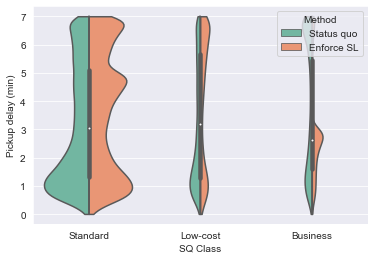

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
sns.despine(left=True)
import numpy as np

print(df_serviced.describe())

print(df_serviced)
fig, ax = plt.subplots(1,1)
g = sns.violinplot(
    x=headers["class"],
    y=headers["delay_pk"],
    hue=headers["method"],
    scale_hue=False,
    data=df_serviced,
    palette="Set2",
    ax=ax,
    cut=0, # Trim edges
    scale="count", # width, area
    #inner="stick", # quartile
    split=True,
    figsize=(300, 3))

# g.figure(figsize=(15,15))
_ = ax.set_yticks(np.arange(0, 480, 60))
_ = ax.set_yticklabels(np.arange(0, 8))

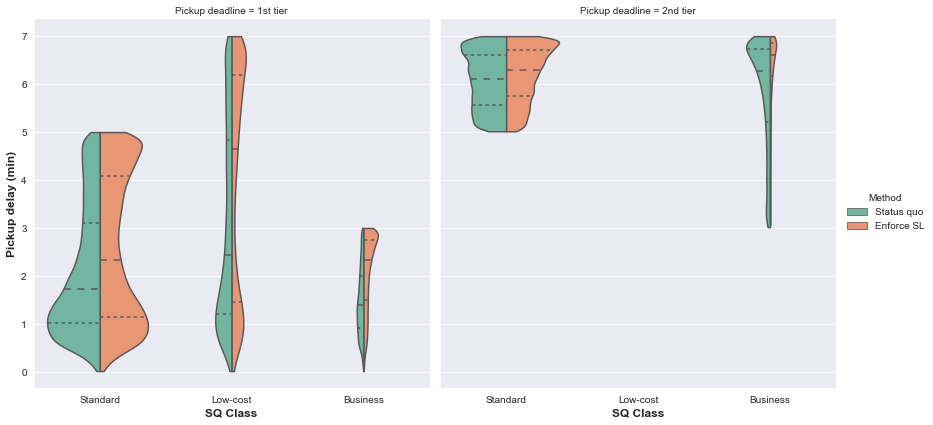

In [78]:
ax = sns.catplot(
    x=headers["class"],
    y=headers["delay_pk"],
    hue=headers["method"],
    col=headers["service_level"],
    inner="quartile",
    data=df_serviced,
    kind="violin",
    split=True,
    scale_hue=False,
    scale="count", # width, area
    palette="Set2",
    height=6,
    cut=0,
    aspect=1)

ax.set(yticks=[i for i in range(0, 480, 60)])
ax.set(yticklabels=[i for  i in range(0, 8)])
ax.set_xlabels(fontweight="bold", fontsize=12)
ax.set_ylabels(fontweight="bold", fontsize=12)
